<a target="_blank" href="https://colab.research.google.com/github.com/giordamaug/HELP/blob/v2.0/notebooks/optuna.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a target="_blank" href="https://www.kaggle.com/notebooks/welcome?src=https://github.com/giordamaug/HELP/blob/v2.0/notebooks/optuna.ipynb">
  <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Colab"/>
</a>

### 1. Load optuna library

In [1]:
import numpy as np
import pandas as pd
import os, sys 
import optuna

### 2. Download the input files
For a chosen tissue (here `Kidney`), download from Zenodo [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.12597679.svg)](https://doi.org/10.5281/zenodo.12597679)
 the label file (here `Kidney_HELP.csv`, computed as in Example 1) and the attribute files (here BIO `Kidney_BIO.csv`, CCcfs `Kidney_CCcfs.csv`, and N2V `Kidney_EmbN2V_128.csv`).  

Skip this step if you already have these input files locally.

In [2]:
from HELPpy.utility.utils import pdread_csv_fromurl
tissue='Kidney'
X_bio = pdread_csv_fromurl(f"https://zenodo.org/records/11917458/files/{tissue}_BIO.csv", index_col=0)
X_n2v = pdread_csv_fromurl(f"https://zenodo.org/records/11917458/files/{tissue}_EmbN2V_128.csv", index_col=0)
X_cccfs = pdread_csv_fromurl(f"https://zenodo.org/records/11917458/files/{tissue}_CCcfs.csv", index_col=0)
Y = pdread_csv_fromurl(f"https://zenodo.org/records/11917458/files/{tissue}_HELP.csv", index_col=0)

### 3. Pre-processing and merge input files
We apply pre-processing only to the BIO and CCcfs attributes.
+ constant attributes removal, and
+ data scaling with z-score.  

We also replace `E` label (positive label) and `aE` and `sNE` labels as 0 label (negative label), to address binary `E vs NE` classification.

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
df_y = Y.replace({'aE': 0, 'sNE': 0, 'E': 1})
print(df_y.value_counts(normalize=False))
consts = X_bio.columns[X_bio.nunique() <= 1].values
print(f"Removing {len(consts)} constant features ...")
X_bio = X_bio.drop(consts, axis=1)
X_bio = pd.DataFrame(StandardScaler().fit_transform(X_bio), index=X_bio.index, columns=X_bio.columns)
X_cccfs = pd.DataFrame(StandardScaler().fit_transform(X_cccfs), index=X_cccfs.index, columns=X_cccfs.columns)
consts = X_cccfs.columns[X_cccfs.nunique() <= 1].values
print(f"Removing {len(consts)} constant features ...")
X_cccfs = X_cccfs.drop(consts, axis=1)
df_X = pd.merge(X_bio, X_n2v, left_index=True, right_index=True, how='outer')
df_X = pd.merge(df_X, X_cccfs, left_index=True, right_index=True, how='outer')
idxs = np.intersect1d(df_y.index.values, df_X.index.values)
df_X = df_X.loc[idxs]
df_y = df_y.loc[idxs]
dataset = pd.concat([df_X,df_y], axis=1)

label
0        16678
1         1253
Name: count, dtype: int64
Removing 0 constant features ...
Removing 3 constant features ...


### 4. Tune model (Optuna)
Start tuning session

In [7]:
import warnings
warnings.filterwarnings("ignore")
from __future__ import annotations
from icarlearn.ensemble.splitvotingens import *
from sklearn.metrics import *
from imblearn.metrics import geometric_mean_score
from optuna import Trial
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective_cv(trial : Trial, X : pd.DataFrame, y : np.ndarray | pd.Series, random_state : int=42):
    params = {
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        'n_voters': trial.suggest_int('n_voters', 1, 20, step=1),
        'n_estimators': trial.suggest_int('n_estimators', 60, 200, step=20),
    }
    gbm = sveLGBM(**params)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    my_scorer = make_scorer(balanced_accuracy_score)
    #my_scorer = make_scorer(geometric_mean_score)
    scores = cross_val_score(gbm, X, y, scoring=my_scorer, cv=kf)
    return np.mean(scores)

savepath = '../pycaret'
study = optuna.create_study(
    study_name=f'svelgbm_{tissue}',
    direction='maximize',
    load_if_exists=True,
    storage=f'sqlite:///{savepath}/sveLGBM_{tissue}_ba_cv.db'
    )
study.optimize(lambda trial: objective_cv(trial, df_X, df_y), n_trials=50)
best_params = study.best_params
print('Best Params:', best_params)
df = study.trials_dataframe()
df.to_csv(os.path.join(f'sveLGBM_{tissue}_hypersearch_ba_cv.csv'))
df.sort_values('value', ascending=False)

[I 2024-07-04 10:55:43,546] A new study created in RDB with name: svelgbm_Kidney


LGBMClassifier(learning_rate=0.0248461687421351, n_estimators=120, verbose=-1)


[I 2024-07-04 10:56:47,274] Trial 0 finished with value: 0.8423182798142357 and parameters: {'learning_rate': 0.0248461687421351, 'n_voters': 4, 'n_estimators': 120}. Best is trial 0 with value: 0.8423182798142357.


LGBMClassifier(learning_rate=0.04595068893557344, verbose=-1)


[I 2024-07-04 10:58:07,822] Trial 1 finished with value: 0.8825998371421111 and parameters: {'learning_rate': 0.04595068893557344, 'n_voters': 11, 'n_estimators': 100}. Best is trial 1 with value: 0.8825998371421111.


LGBMClassifier(learning_rate=0.0016002303899586149, n_estimators=120,
               verbose=-1)


[I 2024-07-04 10:59:42,360] Trial 2 finished with value: 0.8244511361248665 and parameters: {'learning_rate': 0.0016002303899586149, 'n_voters': 15, 'n_estimators': 120}. Best is trial 1 with value: 0.8825998371421111.


LGBMClassifier(learning_rate=0.0021560531082856806, n_estimators=200,
               verbose=-1)


[I 2024-07-04 11:02:34,379] Trial 3 finished with value: 0.8087380880638652 and parameters: {'learning_rate': 0.0021560531082856806, 'n_voters': 19, 'n_estimators': 200}. Best is trial 1 with value: 0.8825998371421111.


LGBMClassifier(learning_rate=0.01061710292709643, n_estimators=200, verbose=-1)


[I 2024-07-04 11:05:31,056] Trial 4 finished with value: 0.862527755664263 and parameters: {'learning_rate': 0.01061710292709643, 'n_voters': 18, 'n_estimators': 200}. Best is trial 1 with value: 0.8825998371421111.


LGBMClassifier(learning_rate=0.011826757340963001, n_estimators=60, verbose=-1)


[I 2024-07-04 11:06:25,194] Trial 5 finished with value: 0.8525893009258467 and parameters: {'learning_rate': 0.011826757340963001, 'n_voters': 15, 'n_estimators': 60}. Best is trial 1 with value: 0.8825998371421111.


LGBMClassifier(learning_rate=0.0032038374530860836, n_estimators=140,
               verbose=-1)


[I 2024-07-04 11:07:33,717] Trial 6 finished with value: 0.6828651919662436 and parameters: {'learning_rate': 0.0032038374530860836, 'n_voters': 6, 'n_estimators': 140}. Best is trial 1 with value: 0.8825998371421111.


LGBMClassifier(learning_rate=0.00802883321752304, n_estimators=80, verbose=-1)


[I 2024-07-04 11:08:45,854] Trial 7 finished with value: 0.8546726544503075 and parameters: {'learning_rate': 0.00802883321752304, 'n_voters': 13, 'n_estimators': 80}. Best is trial 1 with value: 0.8825998371421111.


LGBMClassifier(learning_rate=0.002010040901901548, n_estimators=60, verbose=-1)


[I 2024-07-04 11:09:46,146] Trial 8 finished with value: 0.5 and parameters: {'learning_rate': 0.002010040901901548, 'n_voters': 10, 'n_estimators': 60}. Best is trial 1 with value: 0.8825998371421111.


LGBMClassifier(learning_rate=0.05710066130791045, n_estimators=140, verbose=-1)


[I 2024-07-04 11:11:05,290] Trial 9 finished with value: 0.8870848581954445 and parameters: {'learning_rate': 0.05710066130791045, 'n_voters': 8, 'n_estimators': 140}. Best is trial 9 with value: 0.8870848581954445.


LGBMClassifier(learning_rate=0.09146556119631263, n_estimators=160, verbose=-1)


[I 2024-07-04 11:12:42,524] Trial 10 finished with value: 0.808477662463827 and parameters: {'learning_rate': 0.09146556119631263, 'n_voters': 2, 'n_estimators': 160}. Best is trial 9 with value: 0.8870848581954445.


LGBMClassifier(learning_rate=0.0893491248622469, verbose=-1)


[I 2024-07-04 11:13:48,172] Trial 11 finished with value: 0.8881069187519547 and parameters: {'learning_rate': 0.0893491248622469, 'n_voters': 8, 'n_estimators': 100}. Best is trial 11 with value: 0.8881069187519547.


LGBMClassifier(learning_rate=0.07560145883580464, n_estimators=160, verbose=-1)


[I 2024-07-04 11:15:19,157] Trial 12 finished with value: 0.8882469317660051 and parameters: {'learning_rate': 0.07560145883580464, 'n_voters': 7, 'n_estimators': 160}. Best is trial 12 with value: 0.8882469317660051.


LGBMClassifier(learning_rate=0.09393495320636834, n_estimators=160, verbose=-1)


[I 2024-07-04 11:16:44,250] Trial 13 finished with value: 0.8892691483211632 and parameters: {'learning_rate': 0.09393495320636834, 'n_voters': 7, 'n_estimators': 160}. Best is trial 13 with value: 0.8892691483211632.


LGBMClassifier(learning_rate=0.03295317406647674, n_estimators=180, verbose=-1)


[I 2024-07-04 11:19:02,916] Trial 14 finished with value: 0.7461932268130556 and parameters: {'learning_rate': 0.03295317406647674, 'n_voters': 1, 'n_estimators': 180}. Best is trial 13 with value: 0.8892691483211632.


LGBMClassifier(learning_rate=0.022076075041580386, n_estimators=160, verbose=-1)


[I 2024-07-04 11:20:19,061] Trial 15 finished with value: 0.8653358371139737 and parameters: {'learning_rate': 0.022076075041580386, 'n_voters': 5, 'n_estimators': 160}. Best is trial 13 with value: 0.8892691483211632.


LGBMClassifier(learning_rate=0.09849119540851549, n_estimators=160, verbose=-1)


[I 2024-07-04 11:21:49,640] Trial 16 finished with value: 0.8917341854054097 and parameters: {'learning_rate': 0.09849119540851549, 'n_voters': 8, 'n_estimators': 160}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.04196453872369558, n_estimators=180, verbose=-1)


[I 2024-07-04 11:24:06,964] Trial 17 finished with value: 0.8872392981928992 and parameters: {'learning_rate': 0.04196453872369558, 'n_voters': 10, 'n_estimators': 180}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.01576264442969468, n_estimators=180, verbose=-1)


[I 2024-07-04 11:25:27,518] Trial 18 finished with value: 0.8430325034762894 and parameters: {'learning_rate': 0.01576264442969468, 'n_voters': 4, 'n_estimators': 180}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.0054431895332090465, n_estimators=140,
               verbose=-1)


[I 2024-07-04 11:27:00,098] Trial 19 finished with value: 0.8601254824528546 and parameters: {'learning_rate': 0.0054431895332090465, 'n_voters': 12, 'n_estimators': 140}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.05705304125657472, n_estimators=160, verbose=-1)


[I 2024-07-04 11:28:58,596] Trial 20 finished with value: 0.886633701101931 and parameters: {'learning_rate': 0.05705304125657472, 'n_voters': 9, 'n_estimators': 160}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.0974494790595188, n_estimators=160, verbose=-1)


[I 2024-07-04 11:30:20,389] Trial 21 finished with value: 0.8879094646563501 and parameters: {'learning_rate': 0.0974494790595188, 'n_voters': 7, 'n_estimators': 160}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.06837731574910705, n_estimators=180, verbose=-1)


[I 2024-07-04 11:31:56,895] Trial 22 finished with value: 0.8821528131518155 and parameters: {'learning_rate': 0.06837731574910705, 'n_voters': 6, 'n_estimators': 180}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.03555778457205543, n_estimators=160, verbose=-1)


[I 2024-07-04 11:33:21,391] Trial 23 finished with value: 0.8342191340340298 and parameters: {'learning_rate': 0.03555778457205543, 'n_voters': 3, 'n_estimators': 160}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.0766180503582529, n_estimators=140, verbose=-1)


[I 2024-07-04 11:34:37,217] Trial 24 finished with value: 0.8879673399029413 and parameters: {'learning_rate': 0.0766180503582529, 'n_voters': 7, 'n_estimators': 140}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.001073088062590435, n_estimators=120, verbose=-1)


[I 2024-07-04 11:36:02,290] Trial 25 finished with value: 0.5 and parameters: {'learning_rate': 0.001073088062590435, 'n_voters': 9, 'n_estimators': 120}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.028044249818514427, n_estimators=200, verbose=-1)


[I 2024-07-04 11:38:26,332] Trial 26 finished with value: 0.8860289047912943 and parameters: {'learning_rate': 0.028044249818514427, 'n_voters': 13, 'n_estimators': 200}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.05340341881135604, n_estimators=180, verbose=-1)


[I 2024-07-04 11:39:57,617] Trial 27 finished with value: 0.8766539957767343 and parameters: {'learning_rate': 0.05340341881135604, 'n_voters': 5, 'n_estimators': 180}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.01572482110438377, n_estimators=160, verbose=-1)


[I 2024-07-04 11:41:28,330] Trial 28 finished with value: 0.8702948813092004 and parameters: {'learning_rate': 0.01572482110438377, 'n_voters': 8, 'n_estimators': 160}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.022835172937625794, n_estimators=140, verbose=-1)


[I 2024-07-04 11:42:42,974] Trial 29 finished with value: 0.8503057797795253 and parameters: {'learning_rate': 0.022835172937625794, 'n_voters': 4, 'n_estimators': 140}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.06846946339781423, n_estimators=120, verbose=-1)


[I 2024-07-04 11:43:49,527] Trial 30 finished with value: 0.881066613677201 and parameters: {'learning_rate': 0.06846946339781423, 'n_voters': 6, 'n_estimators': 120}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.09782906480567212, verbose=-1)


[I 2024-07-04 11:44:50,621] Trial 31 finished with value: 0.888138295818076 and parameters: {'learning_rate': 0.09782906480567212, 'n_voters': 8, 'n_estimators': 100}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.099925967041437, verbose=-1)


[I 2024-07-04 11:46:13,205] Trial 32 finished with value: 0.8915232053115947 and parameters: {'learning_rate': 0.099925967041437, 'n_voters': 10, 'n_estimators': 100}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.04274515983020996, n_estimators=80, verbose=-1)


[I 2024-07-04 11:47:19,185] Trial 33 finished with value: 0.876726345263247 and parameters: {'learning_rate': 0.04274515983020996, 'n_voters': 11, 'n_estimators': 80}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.05512800065174187, n_estimators=80, verbose=-1)


[I 2024-07-04 11:48:27,475] Trial 34 finished with value: 0.8848775502091785 and parameters: {'learning_rate': 0.05512800065174187, 'n_voters': 12, 'n_estimators': 80}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.0716980409725318, n_estimators=120, verbose=-1)


[I 2024-07-04 11:50:05,831] Trial 35 finished with value: 0.8877728981313167 and parameters: {'learning_rate': 0.0716980409725318, 'n_voters': 9, 'n_estimators': 120}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.04501210357537029, verbose=-1)


[I 2024-07-04 11:51:25,425] Trial 36 finished with value: 0.8811024123072269 and parameters: {'learning_rate': 0.04501210357537029, 'n_voters': 11, 'n_estimators': 100}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.07391699513802302, n_estimators=140, verbose=-1)


[I 2024-07-04 11:53:23,735] Trial 37 finished with value: 0.8867185934322764 and parameters: {'learning_rate': 0.07391699513802302, 'n_voters': 15, 'n_estimators': 140}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.09835244722478238, n_estimators=200, verbose=-1)


[I 2024-07-04 11:55:08,516] Trial 38 finished with value: 0.8890238016397012 and parameters: {'learning_rate': 0.09835244722478238, 'n_voters': 7, 'n_estimators': 200}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.006429955219775193, n_estimators=200, verbose=-1)


[I 2024-07-04 11:56:38,719] Trial 39 finished with value: 0.8252090774455908 and parameters: {'learning_rate': 0.006429955219775193, 'n_voters': 5, 'n_estimators': 200}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.0042986032380782965, n_estimators=200,
               verbose=-1)


[I 2024-07-04 11:59:01,340] Trial 40 finished with value: 0.8482407193253166 and parameters: {'learning_rate': 0.0042986032380782965, 'n_voters': 16, 'n_estimators': 200}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.08009840556773724, n_estimators=180, verbose=-1)


[I 2024-07-04 12:00:36,368] Trial 41 finished with value: 0.8875704653431417 and parameters: {'learning_rate': 0.08009840556773724, 'n_voters': 7, 'n_estimators': 180}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.0635898528194928, n_estimators=160, verbose=-1)


[I 2024-07-04 12:02:39,888] Trial 42 finished with value: 0.889752334987716 and parameters: {'learning_rate': 0.0635898528194928, 'n_voters': 10, 'n_estimators': 160}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.05959270356585158, n_estimators=200, verbose=-1)


[I 2024-07-04 12:05:08,737] Trial 43 finished with value: 0.8908746230488939 and parameters: {'learning_rate': 0.05959270356585158, 'n_voters': 10, 'n_estimators': 200}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.05909917439393716, n_estimators=80, verbose=-1)


[I 2024-07-04 12:06:16,426] Trial 44 finished with value: 0.8839133901150182 and parameters: {'learning_rate': 0.05909917439393716, 'n_voters': 10, 'n_estimators': 80}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.03537637848373053, n_estimators=180, verbose=-1)


[I 2024-07-04 12:08:27,617] Trial 45 finished with value: 0.8862233885170034 and parameters: {'learning_rate': 0.03537637848373053, 'n_voters': 12, 'n_estimators': 180}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.048076337542907986, n_estimators=140, verbose=-1)


[I 2024-07-04 12:10:46,219] Trial 46 finished with value: 0.8771458980914252 and parameters: {'learning_rate': 0.048076337542907986, 'n_voters': 20, 'n_estimators': 140}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.06315578114943135, n_estimators=160, verbose=-1)


[I 2024-07-04 12:12:47,715] Trial 47 finished with value: 0.8890155793590235 and parameters: {'learning_rate': 0.06315578114943135, 'n_voters': 13, 'n_estimators': 160}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.028516454048403726, n_estimators=120, verbose=-1)


[I 2024-07-04 12:14:20,022] Trial 48 finished with value: 0.8762906353732578 and parameters: {'learning_rate': 0.028516454048403726, 'n_voters': 9, 'n_estimators': 120}. Best is trial 16 with value: 0.8917341854054097.


LGBMClassifier(learning_rate=0.08091938660708022, n_estimators=60, verbose=-1)


[I 2024-07-04 12:15:15,039] Trial 49 finished with value: 0.8835040647930708 and parameters: {'learning_rate': 0.08091938660708022, 'n_voters': 14, 'n_estimators': 60}. Best is trial 16 with value: 0.8917341854054097.


Best Params: {'learning_rate': 0.09849119540851549, 'n_voters': 8, 'n_estimators': 160}


,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_n_estimators,params_n_voters,state
16,16,0.891734,2024-07-04 11:20:19.065674,2024-07-04 11:21:49.634990,0 days 00:01:30.569316,0.098491,160,8,COMPLETE
32,32,0.891523,2024-07-04 11:44:50.626033,2024-07-04 11:46:13.200748,0 days 00:01:22.574715,0.099926,100,10,COMPLETE
43,43,0.890875,2024-07-04 12:02:39.893239,2024-07-04 12:05:08.732783,0 days 00:02:28.839544,0.059593,200,10,COMPLETE
42,42,0.889752,2024-07-04 12:00:36.373211,2024-07-04 12:02:39.883011,0 days 00:02:03.509800,0.063590,160,10,COMPLETE
13,13,0.889269,2024-07-04 11:15:19.161824,2024-07-04 11:16:44.245516,0 days 00:01:25.083692,0.093935,160,7,COMPLETE
38,38,0.889024,2024-07-04 11:53:23.740206,2024-07-04 11:55:08.511564,0 days 00:01:44.771358,0.098352,200,7,COMPLETE
47,47,0.889016,2024-07-04 12:10:46.224222,2024-07-04 12:12:47.710893,0 days 00:02:01.486671,0.063156,160,13,COMPLETE
12,12,0.888247,2024-07-04 11:13:48.176688,2024-07-04 11:15:19.152513,0 days 00:01:30.975825,0.075601,160,7,COMPLETE
31,31,0.888138,2024-07-04 11:43:49.532099,2024-07-04 11:44:50.617137,0 days 00:01:01.085038,0.097829,100,8,COMPLETE
11,11,0.888107,2024-07-04 11:12:42.528982,2024-07-04 11:13:48.167375,0 days 00:01:05.638393,0.089349,100,8,COMPLETE


### 6. Test the best model

In [10]:
df_y.value_counts()

label
0        15994
1         1242
Name: count, dtype: int64

LGBMClassifier(learning_rate=0.09849119540851549, n_estimators=160, verbose=-1)
Classification with sveLGBM...


5-fold:   0%|          | 0/5 [00:00<?, ?it/s]

,measure
ROC-AUC,0.958±0.005
Accuracy,0.916±0.002
BA,0.890±0.009
Specificity,0.920±0.003
Sensitivity,0.859±0.019
G-mean,0.889±0.009
MCC,0.588±0.009


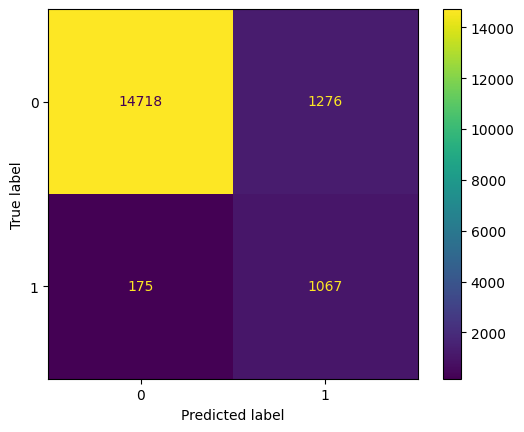

In [8]:
from icarlearn.ensemble.splitvotingens import sveLGBM
from icarlearn.validation.crossvalidate import skfold_cv
from imblearn.metrics import specificity_score, geometric_mean_score

from sklearn.metrics import *
myscorer = { 'ROC-AUC':      (roc_auc_score, {'multi_class':'ovr', 'average':'macro'}),
             'Accuracy'  :   (accuracy_score , {}),
             'BA'  :         (balanced_accuracy_score , {}),
             'Specificity' : (specificity_score, {'pos_label': 1}),
             'Sensitivity' : (recall_score   , {'pos_label': 1}),
             'G-mean' :      (geometric_mean_score   , {'pos_label': 1}),
             'MCC' :         (matthews_corrcoef, {}), 
            }
clf = sveLGBM(**study.best_params)
df_scores, scores, predictions = skfold_cv(df_X, df_y, clf, n_splits=5, seed=0, scorer=myscorer, show_progress=True, verbose=True)
df_scores

In [6]:
#df = pd.read_csv(f'velgbm_{tissue}_hypersearch_mcc_ba_2.csv').sort_values(['values_1', 'values_0'], ascending=[False, False]).rename(columns={'values_0': 'BA', 'values_1': 'MCC'})
df = pd.read_csv(f'velgbm_Kidney_hypersearch_ba_cv.csv').sort_values('value', ascending=False).rename(columns={'value': 'BA'})
df.columns = df.columns.str.replace(r'params_', '')
selcolumns = ['boosting_type',	'learning_rate',	'n_estimators',	'n_voters', 'BA']
stds = df.std(numeric_only=True)
#df['BA+MCC'] = df.apply(lambda x: x.BA * stds.loc['BA'] + x.MCC * stds.loc['MCC'], axis=1)
#df['BA+MCC'] = df.apply(lambda x: x.BA  + x.MCC , axis=1)
print(df[selcolumns].sort_values('BA', ascending=False).to_latex())

\begin{tabular}{llrrrr}
\toprule
 & boosting_type & learning_rate & n_estimators & n_voters & BA \\
\midrule
44 & gbdt & 0.098461 & 200 & 8 & 0.892022 \\
33 & gbdt & 0.081512 & 200 & 8 & 0.890714 \\
43 & gbdt & 0.049017 & 200 & 8 & 0.888816 \\
34 & gbdt & 0.079823 & 200 & 7 & 0.887190 \\
23 & gbdt & 0.065070 & 140 & 13 & 0.886479 \\
48 & gbdt & 0.045185 & 180 & 9 & 0.886413 \\
35 & gbdt & 0.076854 & 200 & 7 & 0.886389 \\
21 & gbdt & 0.050629 & 160 & 9 & 0.886107 \\
49 & gbdt & 0.057144 & 200 & 8 & 0.886095 \\
37 & gbdt & 0.077908 & 200 & 7 & 0.886046 \\
32 & gbdt & 0.034572 & 180 & 11 & 0.885119 \\
22 & gbdt & 0.039571 & 180 & 12 & 0.884895 \\
41 & gbdt & 0.051064 & 200 & 7 & 0.884837 \\
29 & gbdt & 0.030759 & 180 & 10 & 0.884531 \\
6 & gbdt & 0.065527 & 100 & 12 & 0.884275 \\
0 & gbdt & 0.031088 & 180 & 11 & 0.884031 \\
31 & gbdt & 0.031174 & 180 & 10 & 0.883759 \\
15 & gbdt & 0.041630 & 160 & 9 & 0.883406 \\
24 & gbdt & 0.040524 & 140 & 15 & 0.882707 \\
20 & gbdt & 0.099690 & 60 & 10

# Load exisiting study from DB

In [19]:
import optuna
study = optuna.load_study(study_name='velgbm_Kidney', storage="sqlite:///../../results/veLGBM_Kidney_ba_cv.db")

RuntimeError: The runtime optuna version 3.6.1 is no longer compatible with the table schema (set up by optuna 3.1.1). Please execute `$ optuna storage upgrade --storage $STORAGE_URL` for upgrading the storage.

In [24]:
import pandas as pd
print(pd.read_csv("velgbm_Kidney_hypersearch_ba_cv.csv").replace({'':'','':'','':'','':''})sort_values('value', ascending=False).to_latex())

\begin{tabular}{lrrrllllrrrl}
\toprule
 & Unnamed: 0 & number & value & datetime_start & datetime_complete & duration & params_boosting_type & params_learning_rate & params_n_estimators & params_n_voters & state \\
\midrule
37 & 37 & 37 & 0.893151 & 2024-06-05 11:48:54.638670 & 2024-06-05 11:50:51.129284 & 0 days 00:01:56.490614 & gbdt & 0.094505 & 200 & 13 & COMPLETE \\
15 & 15 & 15 & 0.891459 & 2024-06-05 11:16:36.759285 & 2024-06-05 11:17:48.725832 & 0 days 00:01:11.966547 & gbdt & 0.098300 & 140 & 10 & COMPLETE \\
44 & 44 & 44 & 0.890954 & 2024-06-05 12:01:09.467990 & 2024-06-05 12:03:01.279431 & 0 days 00:01:51.811441 & gbdt & 0.076452 & 200 & 12 & COMPLETE \\
43 & 43 & 43 & 0.890826 & 2024-06-05 11:59:18.529245 & 2024-06-05 12:01:09.439684 & 0 days 00:01:50.910439 & gbdt & 0.075168 & 200 & 12 & COMPLETE \\
41 & 41 & 41 & 0.890602 & 2024-06-05 11:55:19.637376 & 2024-06-05 11:57:14.427060 & 0 days 00:01:54.789684 & gbdt & 0.078591 & 200 & 13 & COMPLETE \\
33 & 33 & 33 & 0.890241 & 